In [1]:
!nvidia-smi

Sat Dec 26 09:51:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!unzip '/content/drive/My Drive/train_400X400.zip' 
!unzip '/content/drive/MyDrive/Aerial_Image_Mismatch/train_road.zip'
#!unzip '/content/drive/MyDrive/Aerial_Image_Mismatch/224X224X3_1600_Black/train.zip'

Archive:  /content/drive/MyDrive/Aerial_Image_Mismatch/train_road.zip
  inflating: trainX.hkl              
  inflating: trainY.hkl              


In [5]:
!pip install hickle
import hickle as hkl 
trainX = hkl.load('/content/trainX.hkl')
trainY = hkl.load('/content/trainY.hkl')

     |████████████████████████████████| 51kB 5.7MB/s 


In [5]:
len(trainX)

2609

In [6]:
import numpy as np
X=[]
for i in trainX:
  X.append(i/np.max(i))

Y=[]
for i in trainY:
  Y.append(i/255)

In [7]:
import numpy as np
np.array(X).shape

(2609, 224, 224, 3)

(224, 224, 3)
1.0


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f20f093c5f8>)

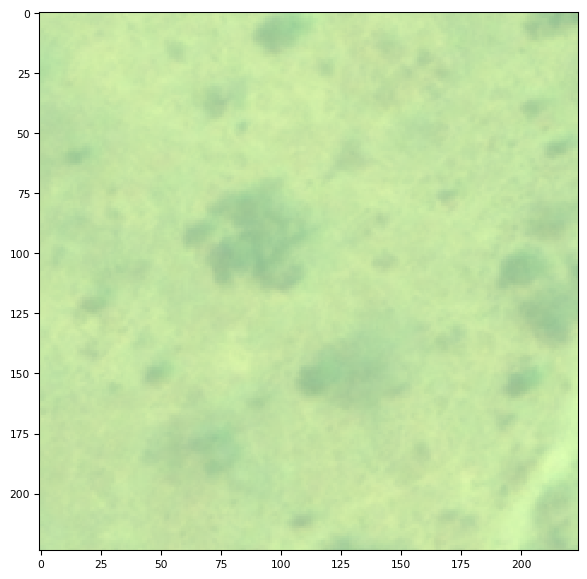

In [8]:
import tifffile as tiff
print(X[50].shape)
print(np.max(X[50]))
tiff.imshow(X[300])

(224, 224, 3)
[0. 1.]


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f20f04a3ba8>)

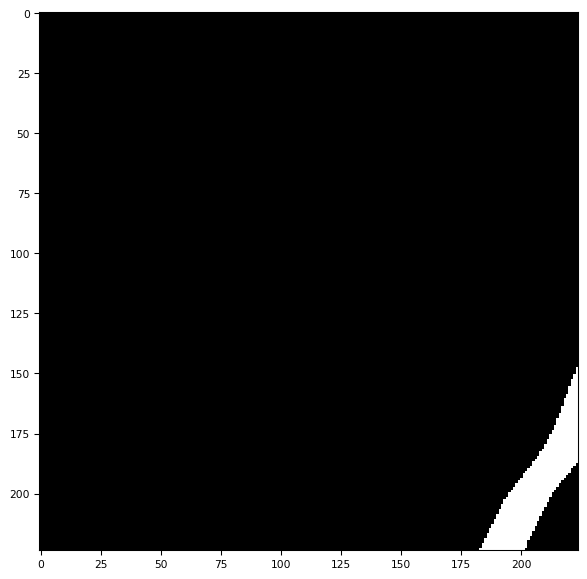

In [9]:
print(Y[50].shape)
print(np.unique(Y[50]))
tiff.imshow(Y[300])

In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow import keras
import os
from keras import backend as K

In [9]:
def jaccard_coef(y_true, y_pred):
    smooth=1e-6
    y_pred = K.round(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[0, -1, -2])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [11]:
def get_unet():
    inp = Input((224,224,3))
    
    conv1 = Conv2D(8, (3,3),padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.5)(conv1)
    conv1 = Conv2D(8, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv1) 
    
    conv2 = Conv2D(16, (3,3), padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.5)(conv2)
    conv2 = Conv2D(16, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Activation('relu')(conv2)
    conv2= BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv2)
    
    conv3 = Conv2D(64, (3,3), padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.5)(conv3)
    conv3 = Conv2D(64, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv3)
    
    conv4 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Activation('relu')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(0.5)(conv4)
    conv4 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv4)
    
    conv5 = Conv2D(256, (3,3), padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Activation('relu')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.5)(conv5)
    conv5 = Conv2D(256, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up1 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(conv5)
    up1 = concatenate([up1,conv4])
    conv6 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(up1)
    conv6 = Activation('relu')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.5)(conv6)
    conv6 = Conv2D(128, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv6) 
    conv6 = Activation('relu')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up2 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(conv6)
    up2 = concatenate([up2,conv3])
    conv7 = Conv2D(64, (3,3), padding = 'same', kernel_initializer = 'he_normal')(up2)
    conv7 = Activation('relu')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.5)(conv7)
    conv7 = Conv2D(64, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = BatchNormalization()(conv7)

    up3 = Conv2DTranspose(32, (2, 2), strides=2, padding='same')(conv7)
    up3 = concatenate([up3,conv2])
    conv8 = Conv2D(32, (3,3), padding = 'same', kernel_initializer = 'he_normal')(up3)
    conv8 = Activation('relu')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.5)(conv8)
    conv8 = Conv2D(32, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = BatchNormalization()(conv8)

    up4 = Conv2DTranspose(16, (2, 2), strides=2, padding='same')(conv8)
    up4 = concatenate([up4,conv1])
    conv9 = Conv2D(16, (3,3), padding = 'same', kernel_initializer = 'he_normal')(up4)
    conv9 = Activation('relu')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(0.5)(conv9)
    conv9 = Conv2D(16, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = BatchNormalization()(conv9)
	
    conv10 = Conv2D(8, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Activation('relu')(conv10)
    conv10 = Dropout(0.5)(conv10)
    conv10 = Conv2D(8, (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv10)
    conv10 = Activation('relu')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(3, (1,1), padding = 'same', kernel_initializer = 'he_normal')(conv10)
    conv10 = Activation('sigmoid')(conv10)
    print(inp.shape)
    print(conv10.shape)
    
    model = Model(inp, conv10)
    
    model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = [jaccard_coef, 'accuracy'])
    return model

In [12]:

def get_inception(inp, filt):
    
    #1X1 conv
    conv1 = Conv2D(filters = filt/4,kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(conv1)

    #1X1_3X3 conv
    conv2 = Conv2D(filters = filt/4,kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(filters = filt/4,kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(conv2)

    #1X1_5X5 conv
    conv3 = Conv2D(filters = filt/4,kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(filters = filt/4,kernel_size = (5,5), padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(conv3)

    #3X3 maxpool 1X1 conv
    pool4 = tf.nn.max_pool2d(inp, ksize = (3,3), strides=1, padding='SAME')
    conv4 = Conv2D(filters = filt/4,kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv4 = Activation('relu')(conv4)
    conv4 = BatchNormalization()(conv4)

    concat = concatenate([conv1, conv2, conv3, conv4])
    #concat = BatchNormalization()(concat)
    return(concat)

In [13]:
def get_Model():
    inpt = Input((224,224,3))
    #print(inpt.shape)
    conv1 = get_inception(inpt, 16)
    conv1 = get_inception(conv1, 16)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv1)
    
    conv2 = get_inception(pool1, 32)
    conv2 = get_inception(conv2, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv2)
    
    conv3 = get_inception(pool2, 64)
    conv3 = get_inception(conv3, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv3)
    
    conv4 = get_inception(pool3, 128)
    conv4 = get_inception(conv4, 128)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv4)

    conv5 = get_inception(pool4, 256)
    conv5 = get_inception(conv5, 256)
    
    up1 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(conv5)
    up1 = concatenate([up1,conv4])
    conv6 = get_inception(up1, 128)
    conv6 = get_inception(conv6, 128)
    
    up2 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(conv6)
    up2 = concatenate([up2,conv3])
    conv7 = get_inception(up2, 64)
    conv7 = get_inception(conv7, 64)
    
    up3 = Conv2DTranspose(32, (2, 2), strides=2, padding='same')(conv7)
    up3 = concatenate([up3,conv2])
    conv8 = get_inception(up3, 32)
    conv8 = get_inception(conv8, 32)

    up4 = Conv2DTranspose(16, (2, 2), strides=2, padding='same')(conv8)
    up4 = concatenate([up4,conv1])
    conv9 = get_inception(up4, 16)
    conv9 = get_inception(conv9, 16)
    conv = Dropout(0.5)(conv9)
    
    conv = Conv2D(3, (1,1), padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv = Activation('sigmoid')(conv)
    #print(conv.shape)


    model = Model(inpt, conv)
    model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = [jaccard_coef, 'accuracy'])
    return model

In [14]:
model = get_unet()
#model = get_Model()

(None, 224, 224, 3)
(None, 224, 224, 3)


In [ ]:
model.summary()

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = [ModelCheckpoint(filepath='/content/checks',
                            save_weights_only=False,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True),
              ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                mode = 'min',
                                min_lr=0.00001,
                                min_delta=0.001,
                                verbose= 1,
                                patience=10)]
            
valX = X[2300:]
valY = Y[2300:]
val_data=(np.array(valX), np.array(valY))
results = model.fit(np.array(X[:2300]), np.array(Y[:2300]), validation_data= val_data, batch_size=8, epochs=250, callbacks= checkpoint)

Epoch 1/250
288/288 [==============================] - 17s 36ms/step - loss: 0.6677 - jaccard_coef: 0.0346 - accuracy: 0.8093 - val_loss: 0.3253 - val_jaccard_coef: 4.0512e-09 - val_accuracy: 1.0000
INFO:tensorflow:Assets written to: /content/checks/assets
Epoch 2/250
288/288 [==============================] - 9s 32ms/step - loss: 0.3204 - jaccard_coef: 3.4785e-05 - accuracy: 0.9867 - val_loss: 0.2370 - val_jaccard_coef: 4.0512e-09 - val_accuracy: 0.9954
Epoch 3/250
288/288 [==============================] - 9s 32ms/step - loss: 0.2763 - jaccard_coef: 1.3449e-04 - accuracy: 0.7165 - val_loss: 0.2417 - val_jaccard_coef: 4.0512e-09 - val_accuracy: 0.0488
Epoch 4/250
288/288 [==============================] - 9s 32ms/step - loss: 0.2697 - jaccard_coef: 9.8380e-06 - accuracy: 0.3448 - val_loss: 0.2272 - val_jaccard_coef: 4.0512e-09 - val_accuracy: 0.2340
Epoch 5/250
288/288 [==============================] - 9s 32ms/step - loss: 0.2605 - jaccard_coef: 1.9915e-05 - accuracy: 0.4438 - val_lo

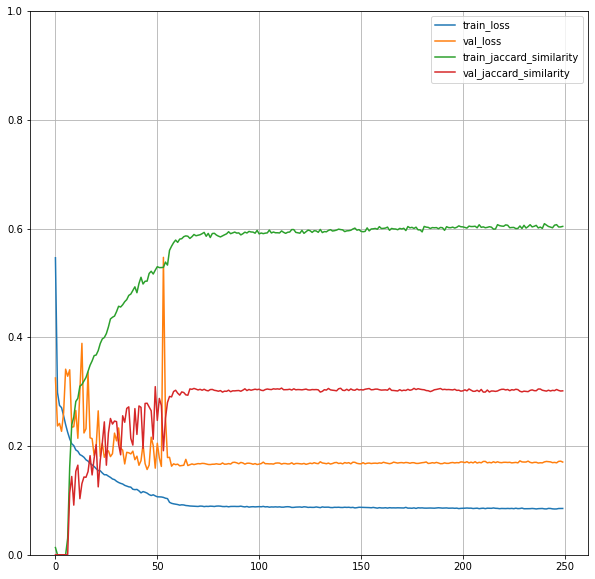

In [16]:
model.save('/content/model_road.h5')
plt.figure(figsize=(10,10))
plt.plot(results.history['loss'], label = 'train_loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.plot(results.history['jaccard_coef'], label = 'train_jaccard_similarity')
plt.plot(results.history['val_jaccard_coef'], label = 'val_jaccard_similarity')
plt.ylim([0,1])
plt.legend()
plt.grid()
plt.show()

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fe35c0c1ac8>)

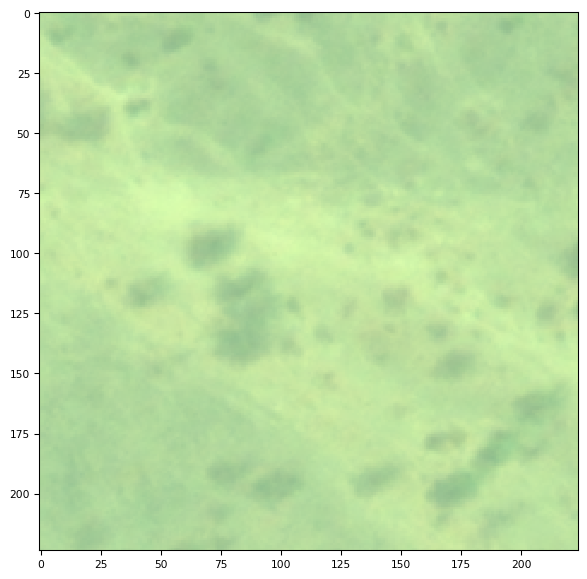

In [17]:
tiff.imshow(X[200])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f1dc47c0c18>)

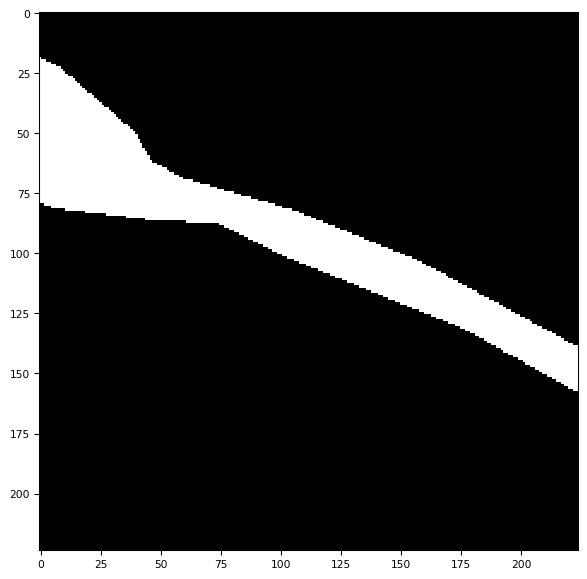

In [19]:
tiff.imshow(Y[200])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fe35cc42c88>)

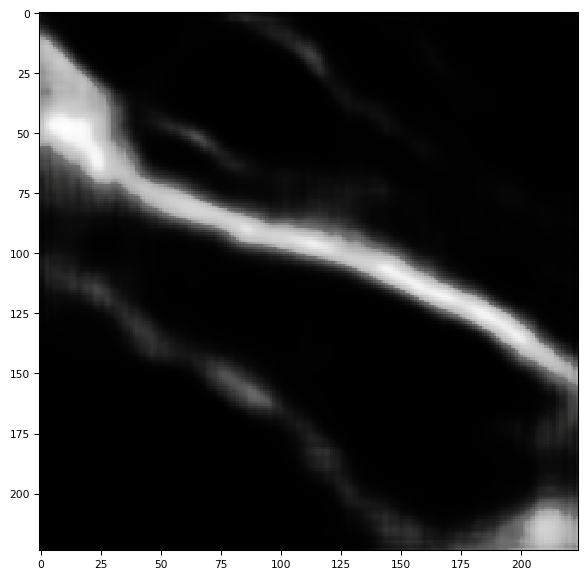

In [18]:
pred = model.predict(np.reshape(X[200], (-1,224,224,3)))
pred = pred * 255
tiff.imshow(np.round(pred))

(None, 224, 224, 3)
(None, 224, 224, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fe357efc208>)

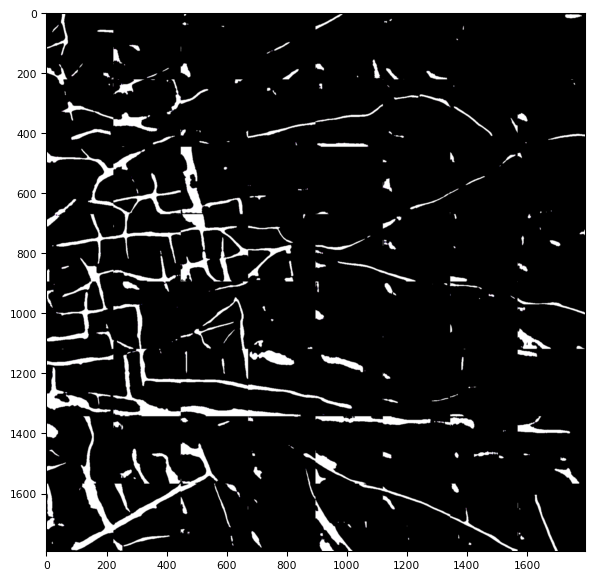

In [21]:
data = plt.imread('/content/drive/MyDrive/Aerial_Image_Mismatch/6120_2_3.jpeg')
#data = tiff.imread('/content/drive/MyDrive/6180_3_2.tif').transpose([1,2,0])
w,h = data.shape[:2]
split = []
hstart = 0
model = get_unet()
#model = get_Model()
model.load_weights('/content/model_road.h5')
#model.load_weights('/content/drive/MyDrive/Aerial_Image_Mismatch/model_crops.h5')
for i in range(1,9):
    hend = (h/8)*i
    wstart=0 
    temp = []
    for j in range(1,9):
        wend = (w/8)*j
        test= data[int(hstart):int(hend), int(wstart):int(wend)]
        img = cv2.resize(test,(224,224), cv2.INTER_AREA)
        img = img/np.max(img)
        pred = model.predict(np.reshape(img, (-1,224,224,3)))
        pred = pred[0,:,:,:3]
        #pred = pred * 255
        temp.append(pred)
        wstart = wend
    split.append(np.concatenate([temp[0],temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7]], axis=1))
    hstart = hend
pred = np.concatenate([split[0],split[1],split[2],split[3],split[4],split[5],split[6],split[7]], axis=0)
tiff.imshow(np.round(pred))

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f1dc14627f0>)

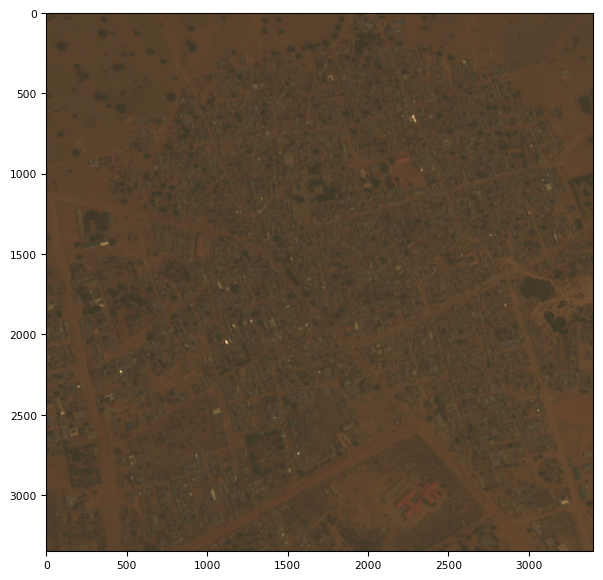

In [22]:
data = plt.imread('/content/drive/MyDrive/Aerial_Image_Mismatch/6120_2_2.jpeg')
#data = tiff.imread('/content/drive/MyDrive/6180_3_2.tif').transpose([1,2,0])
tiff.imshow(data)